In [1]:
#Load Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Load Dataset
diabetes = pd.read_csv('./diabetes.csv')
diabetes.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

In [3]:
#Show Key Statistics
diabetes.describe()

Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  0.078000   21.000000    0.000000  
25%     27.300000                  0.243750   24.000000    0.000000  
50%     32.000000                  0.372500   29.000000    0.000000  
75%     36.600000                  0.626250   41.000000    1.000000  
max     67.100000                  2.420000   81.000000    1.000000

In [4]:
#Summary of N/A Values
diabetes.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [8]:
#Distribution of Classes
diabetes.Outcome.value_counts()

0    500
1    268
Name: Outcome, dtype: int64

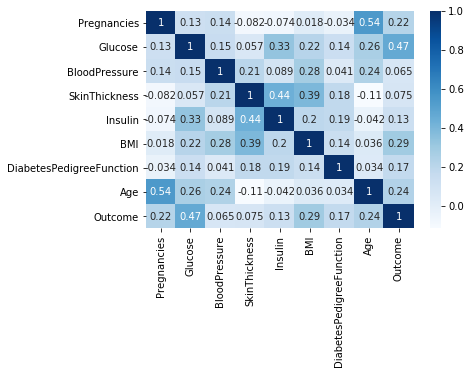

In [9]:
#Visualization of Correlations
import seaborn as sns
sns.heatmap(diabetes.corr(), annot=True,cmap="Blues")

In [10]:
#Identify Correlated Columns
def correlation(dataset,threshold):
    col_corr=set() #set will contain unique values
    corr_matrix=diabetes.corr() #finding correlation between columns
    for i in range (len(corr_matrix.columns)): #Number of columns
        for j in range (i):
            if abs(corr_matrix.iloc[i,j])>threshold: #checking correlation between columns
                colName=corr_matrix.columns[i] #getting column name
                col_corr.add(colName) #adding correlated column name
    return col_corr #returning set of column names
col=correlation(diabetes.drop('Outcome',axis=1),0.8)
print('Correlated columns:', col)

Correlated columns: set()


In [11]:
#Define x and y variables
x = diabetes.drop('Outcome',axis=1).values
y = diabetes['Outcome'].values

LIBRARY AND MODEL IDENTIFICATION

In [12]:
#Load Library for Training dataset
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2, stratify = y, random_state = 100)

In [13]:
#Import Model
from sklearn.linear_model import LogisticRegression

In [15]:
#PIPELINE CREATION
#Construct Pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

pipe_logreg = Pipeline([('scl', StandardScaler()),
                       ('clf', LogisticRegression(class_weight='balanced',
                        random_state=100))])

In [16]:
#Set Grid Search Params
param_gridlogreg = {'clf__C': [0.001,0.1,1,10,100],
                   'clf__penalty': ['l1','l2']}

In [17]:
#Optimize Model
opt_logreg = GridSearchCV(estimator=pipe_logreg, param_grid=param_gridlogreg,
                         cv = 100, verbose=0, scoring='accuracy',n_jobs=-1)

#List of pipelines for ease of iteration
grids=[opt_logreg]

#Dictionary of pipelines and classifier types for ease of reference
grid_dict = {0:'LogReg'}

LOGISTIC REGRESSION MODEL CREATION

In [19]:
#Create Table to Compare MLA metrics

from sklearn.metrics import accuracy_score, precision_score,recall_score
pd.set_option('display.max_colwidth',-1)
MLA_columns=[]
MLA_compare=pd.DataFrame(columns=MLA_columns)

row_index=0
for idx, gs in enumerate(grids):
    
    #Fit Grid Search
    gs.fit(x_train, y_train)
    #Predict on Test Data with Best Params
    y_pred2 = gs.predict(x_test)
    
    #Create Dataframe to Compare Models
    MLA_compare.loc[row_index,'Algorithm Name'] = grid_dict[idx]
    MLA_compare.loc[row_index,'Train Accuracy'] = round(gs.best_score_,2)
    MLA_compare.loc[row_index,'Precision'] = round(precision_score(y_test,y_pred2,average='weighted'),2)
    MLA_compare.loc[row_index,'Recall'] = round(recall_score(y_test,y_pred2,average='weighted'),2)
    MLA_compare.loc[row_index,'MLA Parameters'] = str(gs.best_params_)
    row_index+=1
    
MLA_compare.sort_values(by = ['Precision'], ascending = False, inplace = True)
MLA_compare

Algorithm Name  Train Accuracy  Precision  Recall  \
0  LogReg         0.75            0.76       0.75     

                          MLA Parameters  
0  {'clf__C': 0.1, 'clf__penalty': 'l2'}

PREDICTION

In [23]:
#Prediction Dataset

raw_data = {'Pregnancies':[1],'Glucose':[80],'BloodPressure':[65],'SkinThickness':[35],'Insulin':[80],'BMI':[24],'DiabetesPedigreeFunction':[0.200],'Age':[30]}

dfnew = pd.DataFrame(raw_data, columns = 
                    ['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age'])

dfnew

#Prediction
print('Prediction Outcome - LogReg:', opt_logreg.predict(dfnew))

Prediction Outcome - LogReg: [0]


ROC Curve - Illustrates sensitivity and specificity for all possible cutoff values

In [24]:
#Transform the variables into binary (0,1)
from sklearn import preprocessing

forecast1=pd.DataFrame(y_pred2)
outcome1=pd.DataFrame(y_test)
lbl=preprocessing.LabelBinarizer()
outcomeB1=lbl.fit_transform(outcome1)
forecastB1=lbl.fit_transform(forecast1)

In [25]:
#Setup the ROC Curve
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
fpr,tpr, threshold = metrics.roc_curve(outcomeB1, forecastB1)
roc_auc = metrics.auc(fpr,tpr)

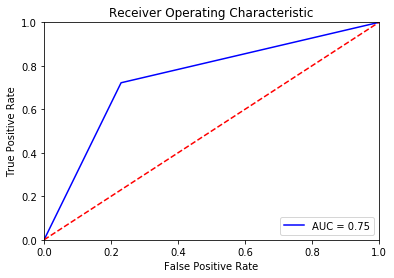

In [26]:
#Plot the ROC Curve
plt.title('Receiver Operating Characteristic')
plt.plot(fpr,tpr,'b',label = 'AUC = %0.2f' %roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()